## Install Dependencies

In [1]:
%pip install matplotlib

import numpy as np
from matplotlib import pyplot as plt
from statistics import mean, median, stdev


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
def printb(text: str) -> None:
    print("\033[1m" + text + "\033[0m")

## Load result data

In [3]:
import json 

with open("experiment_ga_results.json", "r") as results_file:
    experiments = json.load(results_file)

In [4]:
available_tags = set([
    experiment["params"]["tag"] for experiment in experiments
])
print("available tags:", available_tags)

available tags: {'no_caching', 'caching_enabled'}


In [5]:
seeds = [experiment["params"]["seed"] for experiment in experiments]
seeds = list(set(seeds))

print(seeds)

[0, 1, 2, 3, 4]


In [6]:
target_dir = "results_ga" # Used for storing plots

In [7]:
generations = set()
for experiment in experiments:
    generations.add(experiment["params"]["generations"])

assert len(generations) == 1, "Different generation values in experiments!"

generations = list(range(experiments[0]["params"]["generations"]))

In [8]:
no_cache_experiments = [
    experiment for experiment in experiments if experiment["params"]["cache_size"] == 0
]

cache_enabled_experiments = [
    experiment for experiment in experiments if experiment["params"]["cache_size"] > 0
]

print("Experiments without cache:", len(no_cache_experiments))
print("Experiments with cache:", len(cache_enabled_experiments))

Experiments without cache: 5
Experiments with cache: 5


## Plot best and mean fitness

Best and mean fitness, averaged across seeds:


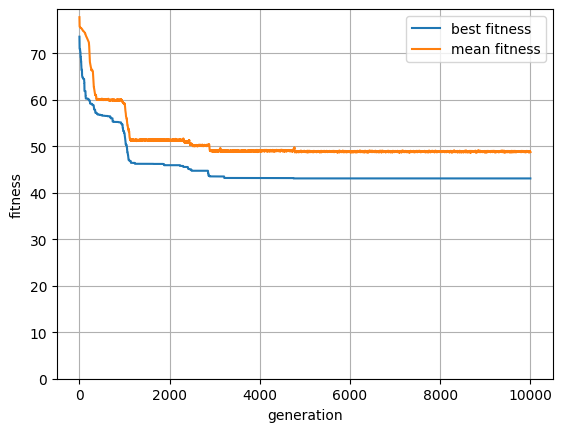

In [9]:
best_fitness_values = []
mean_fitness_values = []

for generation in generations:

    sel_best_fitness_values = [
        experiment["generations"][generation]["best_fitness"] for experiment in experiments
    ]
    best_fitness_values.append(mean(sel_best_fitness_values))
    
    sel_mean_fitness_values = [
        experiment["generations"][generation]["mean_fitness"] for experiment in experiments
    ]
    mean_fitness_values.append(mean(sel_mean_fitness_values))
    
ax = plt.subplot()

ax.plot(generations, best_fitness_values, label="best fitness")
ax.plot(generations, mean_fitness_values, label="mean fitness")

ax.set_xlabel("generation")
ax.set_ylabel("fitness")
ax.set_ylim(0)

printb("Best and mean fitness, averaged across seeds:")

plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/fitness_over_generation.png")

plt.show()

## Plot simulation time


Net simulation time, averaged across seeds:


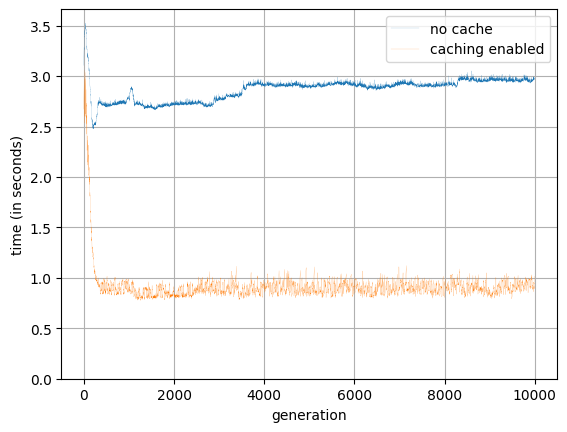

In [10]:
durations_no_cache = []
durations_with_cache = []

for generation in generations:
    sel_durations_no_cache = [
        experiment["generations"][generation]["simulate_without_cache"]["duration"] for experiment in no_cache_experiments
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["generations"][generation]["simulate_using_cache"]["duration"] for experiment in cache_enabled_experiments
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))

ax = plt.subplot()

ax.plot(generations, durations_no_cache, label="no cache", linewidth=0.1)
ax.plot(generations, durations_with_cache, label="caching enabled", linewidth=0.1)

ax.set_xlabel("generation")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Net simulation time, averaged across seeds:")

plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/net_time_over_generation.png")

plt.show()

Total simulation time, averaged across seeds:


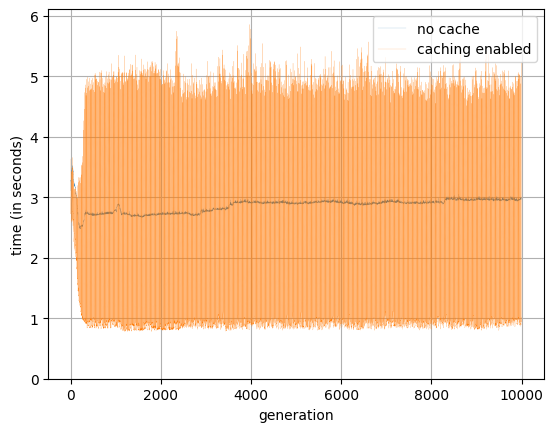

In [11]:
durations_no_cache = []
durations_with_cache = []

for generation in generations:
    duration_no_cache = mean([
        experiment["generations"][generation]["simulate_without_cache"]["duration"] for experiment in no_cache_experiments
    ])
    durations_no_cache.append(duration_no_cache)

    sel_durations_with_cache = []
    for experiment in cache_enabled_experiments:
        simulate_duration = experiment["generations"][generation]["simulate_using_cache"]["duration"] 
        build_cache_duration = experiment["generations"][generation]["build_cache"]["duration"]

        if build_cache_duration is not None:
            sel_durations_with_cache.append(simulate_duration + build_cache_duration)
        else: 
            sel_durations_with_cache.append(simulate_duration)

    duration_with_cache = mean(sel_durations_with_cache)
    durations_with_cache.append(duration_with_cache)


ax = plt.subplot()
ax.plot(generations, durations_no_cache, label="no cache", linewidth=0.1)
ax.plot(generations, durations_with_cache, label="caching enabled", linewidth=0.1)
ax.set_xlabel("generation")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time, averaged across seeds:")

plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_over_generation.png")

plt.show()

Total simulation time with caching disabled:


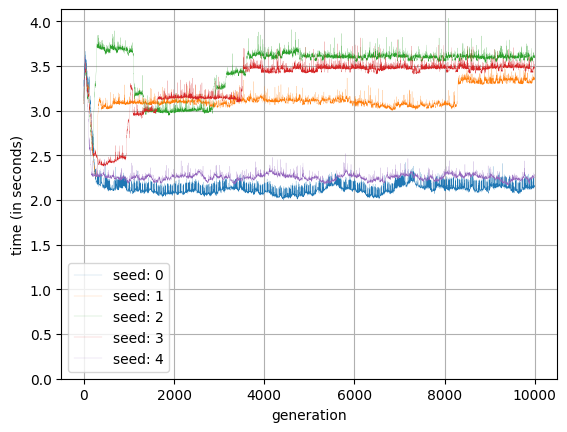

In [12]:
# plot simulation time of each seed without cache

ax = plt.subplot()

for seed in seeds:
    seed_durations_no_cache = []

    for generation in generations:
        sel_durations_no_cache = [
            experiment["generations"][generation]["simulate_without_cache"]["duration"] 
            for experiment in no_cache_experiments 
            if experiment["params"]["seed"] == seed
        ]

        assert len(sel_durations_no_cache) == 1, "Too many results for one seed value!"

        seed_durations_no_cache.append(sel_durations_no_cache[0])

    ax.plot(generations, seed_durations_no_cache, label=f"seed: {seed}", linewidth=0.1)

ax.set_xlabel("generation")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)


printb("Total simulation time with caching disabled:")
plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_per_generation_disabled_by_seed.png")
plt.show()

Total simulation time with caching enabled:


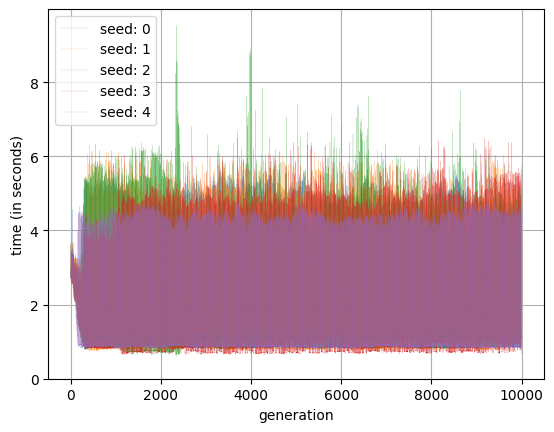

In [13]:
# plot simulation time of each seed with cache

ax = plt.subplot()

for seed in seeds:
    seed_durations_with_cache = []

    for generation in generations:

        sel_durations_with_cache = []

        for experiment in cache_enabled_experiments:
            if experiment["params"]["seed"] != seed:
                continue 

            simulate_duration = experiment["generations"][generation]["simulate_using_cache"]["duration"] 
            build_cache_duration = experiment["generations"][generation]["build_cache"]["duration"]

            if build_cache_duration is not None:
                sel_durations_with_cache.append(simulate_duration + build_cache_duration)
            else: 
                sel_durations_with_cache.append(simulate_duration)

        assert len(sel_durations_with_cache) == 1, "Too many results for one seed value!"

        seed_durations_with_cache.append(sel_durations_with_cache[0])

    ax.plot(generations, seed_durations_with_cache, label=f"seed: {seed}", linewidth=0.1)

ax.set_xlabel("generation")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)


printb("Total simulation time with caching enabled:")
plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_per_generation_enabled_by_seed.png")
plt.show()

Cummulative total simulation time, averaged across seeds:
Total simulation time without caching at generation 9999: 28626.120558199997
Total simulation time with caching at generation 9999: 13192.819348399982


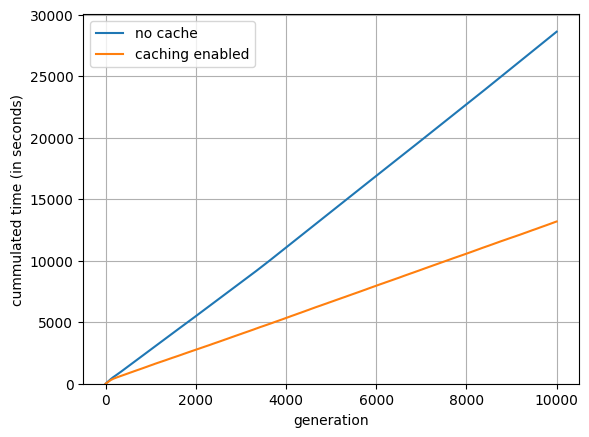

In [14]:
durations_no_cache = []
stdevs_no_cache = []

durations_with_cache = []
stdevs_with_cache = []

for generation in generations:
    duration_no_cache = mean([
        experiment["generations"][generation]["simulate_without_cache"]["duration"] for experiment in no_cache_experiments
    ])
    durations_no_cache.append(duration_no_cache)

    sel_durations_with_cache = []
    for experiment in cache_enabled_experiments:
        simulate_duration = experiment["generations"][generation]["simulate_using_cache"]["duration"] 
        build_cache_duration = experiment["generations"][generation]["build_cache"]["duration"]

        if build_cache_duration is not None:
            sel_durations_with_cache.append(simulate_duration + build_cache_duration)
        else: 
            sel_durations_with_cache.append(simulate_duration)

    duration_with_cache = mean(sel_durations_with_cache)
    durations_with_cache.append(duration_with_cache)


for i, (duration_no_cache, duration_with_cache) in enumerate(zip(durations_no_cache, durations_with_cache)):
    if i == 0:
        continue

    durations_no_cache[i] = durations_no_cache[i - 1] + duration_no_cache
    durations_with_cache[i] = durations_with_cache[i - 1] + duration_with_cache


ax = plt.subplot()
ax.plot(generations, durations_no_cache, label="no cache")
ax.plot(generations, durations_with_cache, label="caching enabled")
ax.set_xlabel("generation")
ax.set_ylabel("cummulated time (in seconds)")
ax.set_ylim(0)

printb("Cummulative total simulation time, averaged across seeds:")

print(f"Total simulation time without caching at generation {generations[-1]}: {durations_no_cache[-1]}")
print(f"Total simulation time with caching at generation {generations[-1]}: {durations_with_cache[-1]}")

plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/cum_total_time_over_generation.png")

plt.show()

## Plot redundancy

Population redundancy, averaged across seeds:


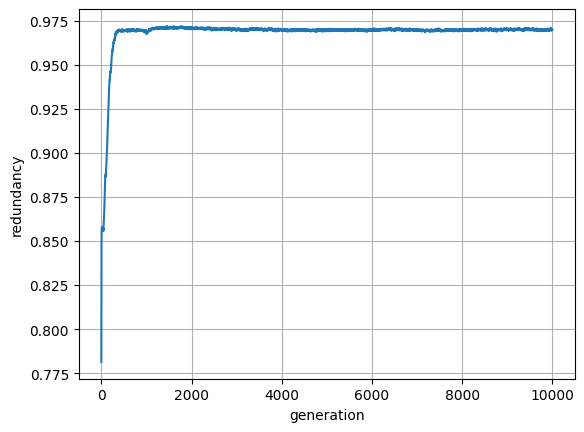

In [15]:
redundancies = []

for generation in generations:

    sel_redundancies = [
        experiment["generations"][generation]["population_redundancy"] for experiment in experiments
    ]
    redundancies.append(mean(sel_redundancies))

ax = plt.subplot()
ax.plot(generations, redundancies)
ax.set_xlabel("generation")
ax.set_ylabel("redundancy")
# ax.set_ylim(0)

printb("Population redundancy, averaged across seeds:")

plt.grid()

plt.savefig(f"{target_dir}/redundancy_over_generation.png")

plt.show()

## Show gate distributions over time

Frequency by gate type:


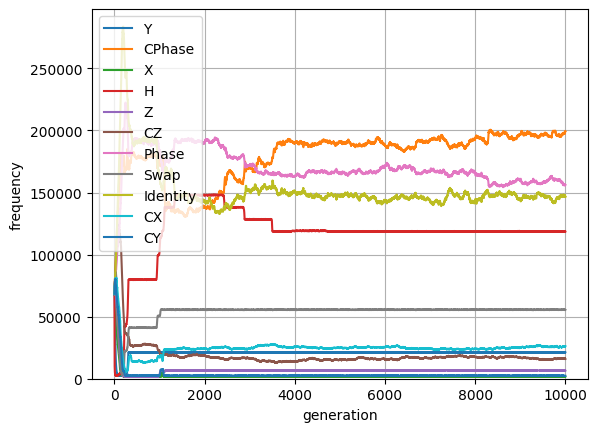

In [16]:
gate_type_dists = {}

for generation in generations:
    
    sel_gate_type_dists = [
        experiment["generations"][generation]["gate_type_dist"] for experiment in experiments
    ]

    for gate_type_dist in sel_gate_type_dists:
        for gate_type in gate_type_dist:
            
            # add gate types that have not occurred previously
            if gate_type not in gate_type_dists:
                gate_type_dists[gate_type] = [0] * generation 

            # 
            if len(gate_type_dists[gate_type]) < generation + 1:
                for _ in range(generation + 1 - len(gate_type_dists[gate_type])):
                    gate_type_dists[gate_type].append(0)

            gate_type_dists[gate_type][-1] += gate_type_dist[gate_type]

# for gate_type in gate_type_dists:
#     if len(gate_type_dists[gate_type]) < generation:
#         for _ in range(generation + 1 - len(gate_type_dists[gate_type])):
#             gate_type_dists[gate_type].append(0)

dist_lengths = [len(gate_type_dists[gate_type]) for gate_type in gate_type_dists]
assert len(set(dist_lengths)) == 1

ax = plt.subplot()

for gate_type in gate_type_dists:
    ax.plot(generations, gate_type_dists[gate_type], label=gate_type)

ax.set_xlabel("generation")
ax.set_ylabel("frequency")
ax.set_ylim(0)

printb("Frequency by gate type:")

plt.legend()
plt.grid()

plt.show()


Frequency by gate type:


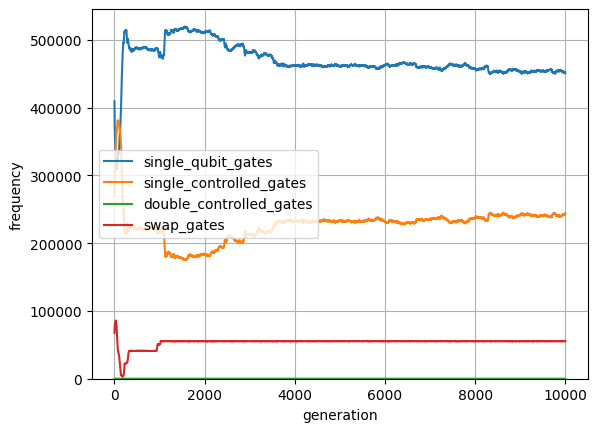

In [17]:
ax = plt.subplot()

single_qubit_gates = [0] * len(generations)
single_controlled_gates = [0] * len(generations)
double_controlled_gates = [0] * len(generations)
swap_gates = [0] * len(generations)

for gate_type in gate_type_dists:

    if gate_type in ["X", "Y", "Z", "S", "T", "H", "Identity", "Phase"]:
        for i, frequency in enumerate(gate_type_dists[gate_type]):
            single_qubit_gates[i] += frequency
    elif gate_type in ["CX", "CY", "CZ", "CS", "CT", "CPhase"]:
        for i, frequency in enumerate(gate_type_dists[gate_type]):
            single_controlled_gates[i] += frequency
    elif gate_type in ["CCX", "CCZ"]:
        for i, frequency in enumerate(gate_type_dists[gate_type]):
            double_controlled_gates[i] += frequency
    elif gate_type == "Swap":
        for i, frequency in enumerate(gate_type_dists[gate_type]):
            swap_gates[i] += frequency
    else:
        raise NotImplementedError(f"No handling strategy for gate type '{gate_type}' has been implemented.")

ax.plot(generations, single_qubit_gates, label="single_qubit_gates")
ax.plot(generations, single_controlled_gates, label="single_controlled_gates")
ax.plot(generations, double_controlled_gates, label="double_controlled_gates")
ax.plot(generations, swap_gates, label="swap_gates")

ax.set_xlabel("generation")
ax.set_ylabel("frequency")
ax.set_ylim(0)

printb("Frequency by gate type:")

plt.legend()
plt.grid()

plt.show()